*Hello*, I will assume you are here because you saw my lecture or a recording of it. If you haven't seen it, you might feel a bit lost, but you can check for a link on GitHub repository this notebook is hosted on for more info.

Occasionally, we load the libraries with `import`. If you do not have them at your end and you want to run this on your own computer, make sure you install Python 3 first and then use `pip` to gather the rest. 

If you have no idea how to locally interact with this kind of a file, it's called a Jupyter notebook and it is easy enough to install on your own computer (it will open in your browser).

Now, we decide how many cities we are working with.

In [1]:
from sys import argv # read command-line parameters                                                                                                                                                                                                           
n = None                                                                                                                                                                                                                                                      
try:                                                                                                                                                                                                                                                          
    n = int(argv[1]) # how many cities does our TSP have                                                                                                                                                                                                      
except:                                                                                                                                                                                                                                                       
    n = 5 # a small default                                                                                                                                                                                                                                   
assert n > 2 # we need at least three for this to make sense                                                                                                                                                                                                  
print(f'Working with a TSP of {n} cities')    

Working with a TSP of 5 cities


Then some parameters for the visualizations we will be making. Do not worry about understanding these unless you are a programmer, but play with them to see what happens if you change the numbers :)

In [2]:
from math import sqrt, log, ceil, exp, fabs # mathematical routines  
unit = 8
width = int(n * sqrt(n))
wunit = (width / n) * unit
radius = 1 / n
magn = int(ceil(log(n, 2)))
significant = 0.01
gns = max(50, 300 - 20 * int(log(n, 2))) if n <= 30 else 20 # node size for graphs
tns = max(150, 400 - 20 * int(log(n, 2))) if n < 5 else 20 # node size for trees

In order to *measure time*, let's have a small auxiliary routine to print that out when we want to see it.

In [15]:
from time import time    
def timestamp(start):
    ms = 1000 * (time() - start)
    print(f'That took {ms:.2f} ms of runtime')

OK, now we are ready to roll. To build the graph, we are going to use **Euclidean distances** as the costs of the edges.

In [16]:
def eucl(p1, p2):
    (vx, vy) = p1
    (wx, wy) = p2
    dx = vx - wx # horizontal difference
    dy = vy - wy # vertical difference
    return sqrt(dx**2 + dy**2) # remember Pythagoras?

Let's build a graph. We *could* of course do the creation of the graph using a library routine from networkx, but we *learn* more if we do it step by step.

In [17]:
from networkx import Graph, draw, relabel_nodes
G = Graph() # storage for the graph
gpos = dict() # storage for the vertex positions
v = 0

from random import random, shuffle, randint # pseudo-random number generation  
while v < n: # add a total of n vertices called 0, 1, 2, ..., n - 1
    # position each vertex pseudo-randomly in a unit square
    x = random() # horizontal position
    y = random() # vertical position
    p = (x, y)
    close = False
    for w in G.nodes(): # check that it is not too close
        distance = eucl(p, gpos[w])
        if distance < radius:
            close = True
            break
    if not close:
        G.add_node(v)
        gpos[v] = (x, y)
        v += 1

Now we have nodes and we know their positions. We need to add the edges. While at it, we can figure out what is the lowest and the highest cost of a single edge in the graph we have created. Also note that no solution could ever cost more than **all** the edges.

In [18]:
low = sqrt(2) # the highest possible Euclidean distance in a unit square
high = 0 # the lowest possible distance
edgecosts = dict()
for v in gpos: # for each vertex
    for w in gpos: # for each other vertex
        if v == w:
            continue # skip self
        d = eucl(gpos[v], gpos[w])
        G.add_edge(v, w, cost = d)
        edgecosts[(v, w)] = d
        edgecosts[(w, v)] = d
        low = min(low, distance) # figure out the minimum edge cost
        high = max(high, distance) # as well as the maximum
# view the min-max edgecosts at two-decimal precision
print(f'The minimum single-edge cost is {low:.2f} and the maximum is {high:.2}')
worst = sum(edgecosts.values()) / 2 

The minimum single-edge cost is 0.74 and the maximum is 0.74


We should take a moment to admire the creation. To draw it, first we set up how we want the visualization to look.

In [19]:
opt = { 'node_color': 'white', 'font_color': 'black' }
opt['with_labels'] = n <= 30
opt['node_size'] = gns
opt['width'] = max(4 - magn, 1)
import matplotlib.pyplot as plt # for the drawings 
plt.rcParams['figure.figsize'] = (unit, unit) # big figure

Now, in case you want to experiment with really big graphs later on, we might not want to *draw* those since it will get messy. So I will put a little safeguard here and there in case we forget there is heavy calculations ahead and input a value for `n` that is a bit too big to swallow.

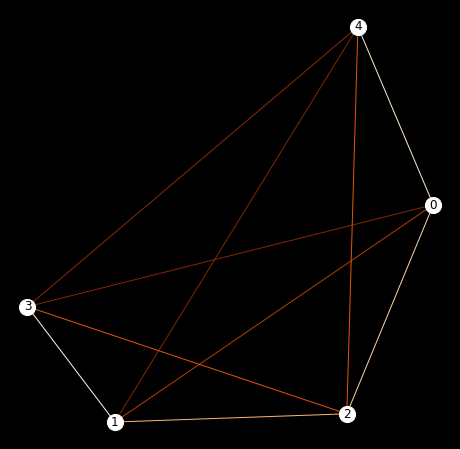

In [20]:
if n <= 150:
    fig, ax = plt.subplots() # create an image to draw onto
    draw(G, pos = gpos, # place each vertex in the unit square using its coordinates
         edge_cmap = plt.get_cmap('Oranges'), # use tones of orange to color the edges
         edge_color = [ edgecosts[(v, w)] for v, w in G.edges() ], # the tone of each depends on its cost
         **opt) # use the options above
    ax.set_facecolor('black') # make it a black background
    fig.set_facecolor('black')
    ax.axis('off') # no axis needed
    plt.show()
    plt.close()

For the **exhaustive** solution, we need to explore the tree of all the possible orderings of the visits. Here is a home-made implementation of a data structure to take care of that part. Studying its inner workings can be interesting for students of data structures or discrete mathematics ;) Others can just take this at face value and skip ahead.

In [21]:
class Node: # now, consider all the possible visitation orders as a tree 

    def __init__(self, label, parent = None, depth = 0): # create an empty node
        self.value = label # store the value
        self.parent = parent # root has none
        self.children = None # leaves have none
        self.depth = depth # the root is at zero
        self.height = None
        self.x = None
        self.y = None
        self.path = ''
        self.cost = 0
        self.total = 0
        self.label = None
        
    def adjust(self): # set values for height
        tallest = [ child.adjust() for child in self.children ] if self.children is not None else [ 0 ]
        self.height = 1 + max(tallest) # leaves have height one 
        return self.height
        
    def __str__(self): # print the node (recursively the tree)
        prefix = ' ' * self.depth
        below = '\n'.join(str(child) for child in self.children) if self.children is not None else ''
        return f'{prefix}{self.path}\n{below}'.rstrip() 

    def __repr__(self):
        return str(self) # when asked to represent, use the above format
    
    def present(self): # what values are already present at or above this one
        above = self.parent.present() if self.parent is not None else set()
        return { self.value } | above

    def permute(self, values, source, root, best):
        if self.parent is not None: # not the root
            self.path = self.parent.path + '.' + str(self.value)
            # the cost of the edge from the parent to this one in the graph
            self.cost = source[(self.value, self.parent.value)]
            self.total = self.cost + self.parent.total
        else:
            self.path = str(self.value)
        pending = sorted(list(values - self.present())) # skip those already present
        if len(pending) == 0: # nothing left (a leaf)
            closing = source[(self.value, root.value)]
            self.total += closing # close the loop
            return min(self.total, best)
        d = self.depth + 1 # the children will be one level deeper
        self.children = [ Node(value, parent = self, depth = d) for value in pending ]
        below = values - { self.value }
        for child in self.children: # continue recursively
            best = min(best, child.permute(below, source, root, best))
        return best
    
    def position(self, ltarget, ptarget, xr, y, dy):
        self.label = f'{self.path} = {self.total:.2f}' # make a label with total cost
        ltarget[self.path] = self.label 
        (xlow, xhigh) = xr
        self.x = (xlow + xhigh) / 2 # horizontally in the middle
        self.y = y # vertical position
        ptarget[self.label] = (self.x, self.y) # associate positions to the labels
        if self.children is not None:
            xspan = xhigh - xlow
            xa = xspan / len(self.children) # horizontal allocation per child
            for child in self.children:
                child.position(ltarget, ptarget, (xlow, xlow + xa), y - dy, dy)
                xlow += xa

    
    def join(self, graph): # add nodes as vertices to draw with networkx
        graph.add_node(self.path)
        if self.children is not None:
            for child in self.children:
                child.join(graph)

    def connect(self, graph): # add connections as edges to draw with networkx
        if self.parent is not None:
            v = self.label
            w = self.parent.label
            graph.add_edge(v, w, cost = self.cost)
        if self.children is not None:
            for child in self.children:
                child.connect(graph)

    def cheapest(self, best):
        if self.children is None: # at a leaf
            return min(self.total, best)
        else: # not at a leaf yet
            return min([ child.cheapest(best) for child in self.children ])

Of course we want to draw this as well, since we are learning about how things work. First we will adjust the drawing options to better match this scenario.

In [22]:
opt['with_labels'] = n < 5
opt['font_color'] = 'cyan'
opt['node_size'] = tns

Then another little safeguard (beware the combinatorial explosion).

The cheapest (exhaustive) route edgecosts 2.07
That took 0.26 ms of runtime


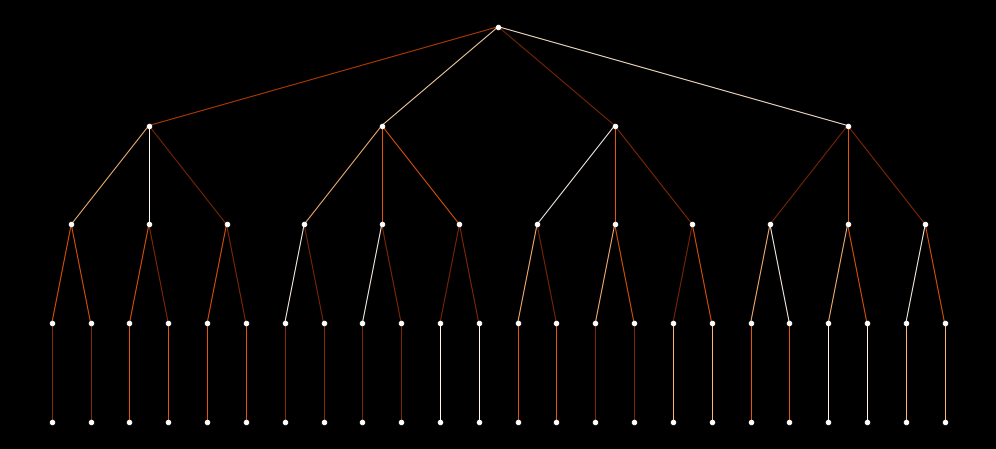

In [23]:
if n < 11: # too slow for larger graphs
    # note that it does not matter where we start since it is a cycle
    start = time()
    groot = Node(0) # we can start at zero w.l.o.g.
    gbest = groot.permute({ v for v in range(n) }, edgecosts, groot, worst)
    print(f'The cheapest (exhaustive) route edgecosts {gbest:.2f}')
    timestamp(start)
    groot.adjust()
    T = Graph() # we make a graph of it so we can draw it the same way
    groot.join(T) # create vertices to represent the nodes
    labels = dict()
    tpos = dict()
    plt.rcParams['figure.figsize'] = (wunit, unit) # big figure
    groot.position(labels, tpos, (0, w), 1, 1 / (n + 1)) # label and position the nodes with
    L = relabel_nodes(T, labels)
    groot.connect(L) # add edges to represent the branches and match the edgecosts
    if n < 7: # makes no sense for large n to draw the trees
        fig, ax = plt.subplots()
        draw(L, pos = tpos, # using the tree positions
             edge_cmap = plt.get_cmap('Oranges'),
             edge_color = [ data['cost'] for v, w, data in L.edges(data = True) ], **opt) 
        ax.set_facecolor('black')
        fig.set_facecolor('black')
        plt.show()
        plt.close()        

Remember to be smart and prune branches that cost more than the best one seen thus far. We will be object-oriented and inherit a new class from the `Node` defined above. Do not worry about what exactly this is unless you are supposed to know OOP; we are just adding a bit of new functionality to what we defined above to make it act smarter.

In [24]:
class Smart(Node):

    def __init__(self, label, parent = None, depth = 0):
        super().__init__(label, parent, depth)
        self.complete = False

    def role(self, target):
        # complete leaves are 1, incomplete leaves are 0, internals are -1
        target[self.label] = 1 * self.complete if self.children is None else -1 
        if self.children is not None:
            for child in self.children: 
                child.role(target)
        
    def permute(self, values, source, root, best): # redefine how to proceed
        if self.parent is not None:
            self.path = self.parent.path + '.' + str(self.value)
            self.cost = source[(self.value, self.parent.value)]
            self.total = self.cost + self.parent.total
            if self.total > best: # already more expensive, makes no sense to continue
                self.path += str(self.value) # leave early
                return best # this becomes an incomplete route if not a leaf yet
        else:
            self.path = str(self.value)
        pending = sorted(list(values - self.present())) # skip those already present
        if len(pending) == 0: # nothing left (a leaf)
            closing = source[(self.value, root.value)]
            self.total += closing
            self.complete = True
            return min(self.total, best)
        d = self.depth + 1 
        self.children = [ Smart(value, parent = self, depth = d) for value in pending ]
        below = values - { self.value }
        for child in self.children: 
            best = min(best, child.permute(below, source, root, best))
        return best

Gonna fiddle with the display options again. You can adjust these to your liking in case you want the circles to be pink or the labels to be smaller.

In [25]:
opt['font_color'] = 'cyan'
opt['font_size'] = 12

A safeguard and then we draw.

The cheapest (pruned) route edgecosts 2.07
That took 0.48 ms of runtime


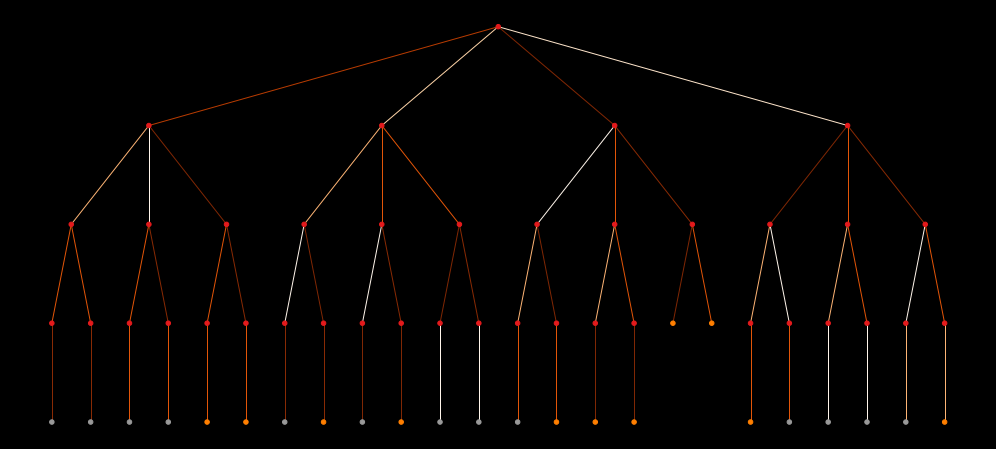

In [26]:
if n < 13:
    start = time()
    sroot = Smart(0)
    sbest = sroot.permute({ v for v in range(n) }, edgecosts, sroot, worst)
    print(f'The cheapest (pruned) route edgecosts {sbest:.2f}')
    timestamp(start)
    assert fabs(gbest - sbest) < significant
    sroot.adjust()
    P = Graph() 
    sroot.join(P)
    h = sroot.height
    sroot.position(labels, tpos, (0, w), 1, 1 / (n + 1)) # label and position the nodes with
    Q = relabel_nodes(P, labels)
    sroot.connect(Q) # add edges to represent the branches and match the edgecosts
    del opt['node_color']
    if n < 7: 
        complete = dict()
        sroot.role(complete)
        nodecolor = [ complete[v] for v in Q.nodes() ] # intermediate, full solution or pruned 
        fig, ax = plt.subplots()
        draw(Q, pos = tpos, 
             node_color = nodecolor,
             cmap = plt.get_cmap('Set1'),
             edge_cmap = plt.get_cmap('Oranges'),
             edge_color = [ data['cost'] for v, w, data in Q.edges(data = True) ], **opt) 
        ax.set_facecolor('black')
        fig.set_facecolor('black')
        ax.axis('off')
        plt.show()
        plt.close()        

If `n` is small, it is not often that branches get pruned, but with larger quantities it gets more common. 

So, now, idea number one to save time: *self-avoiding random walks*. To start with, we could use an auxiliary routine to tell us how much a route we have come up with actually costs.

In [27]:
def cost(G, route):
    acc = 0 # accumulate the cost here
    p = 1 # by traversing the route
    while p < len(route):
        source = route[p - 1]
        target = route[p]
        d = G.get_edge_data(source, target)
        assert 'cost' in d
        acc += d['cost']
        p += 1
    return acc

Now we can make some random walks and see how bad they are (if our `n` was small enough for us to see the optimal cost).

In [28]:
start = time()                                                                                                                                                                                                                                                
route = [ v for v in range(n) ]                                                                                                                                                                                                                               
replicas = 10 * magn                                                                                                                                                                                                                                          
rbest = worst                                                                                                                                                                                                                                                 
bestwalk = None                                                                                                                                                                                                                                               
# let's remember some of these for later                                                                                                                                                                                                                      
memories = dict()                                                                                                                                                                                                                                             
for replica in range(replicas): # try several times                                                                                                                                                                                                           
    shuffle(route) # a new permutation                                                                                                                                                                                                                        
    cycle = route + [ route[0] ] # close the cycle                                                                                                                                                                                                            
    c = cost(G, cycle)                                                                                                                                                                                                                                        
    if c < rbest:                                                                                                                                                                                                                                             
        rbest = c                                                                                                                                                                                                                                             
        bestwalk = cycle.copy()                                                                                                                                                                                                                               
        memories[f'BRW'] = bestwalk                                                                                                                                                                                                                           
    if replica < 5:                                                                                                                                                                                                                                           
        memories[f'RW{replica}'] = cycle.copy()                                                                                                                                                                                                               
print(f'The cheapest random walk costs {rbest:.2f} (over {replicas} attempts)')                                                                                                                                                                               
timestamp(start)  

The cheapest random walk costs 2.07 (over 30 attempts)
That took 0.57 ms of runtime


Of course I want to draw the best of these just to see the mess I have made. So let us restore some drawing options to go back to drawing graphs instead of trees. 

In [29]:
plt.rcParams['figure.figsize'] = (unit, unit) # restore some of these                                                                   
opt['node_size'] = gns                                                                                                                  
opt['node_color'] = 'white'                                                                                                             
opt['with_labels'] = n <= 30                                                                                                            
opt['font_color'] = 'black'      

Also, in order not to lose the graph itself, we need a *copy* of it so we can get rid of all the edges that are not part of the random walk. Then, when we draw the rest, we just see the route we have created.

In [30]:
def used(r):                                                                                                                            
    u = set()                                                                                                                           
    for p in range(len(r)  - 1):                                                                                                        
        a = r[p]                                                                                                                        
        b = r[p + 1]                                                                                                                    
        u.add((a, b))                                                                                                                   
        u.add((b, a))                                                                                                                   
    return u                                                                                                                            
                                                                                                                                        
W = G.copy() # make a copy                                                                                                              
removed = G.edges() - used(bestwalk)                                                                                                    
W.remove_edges_from(removed)             

A safeguard and then we draw.

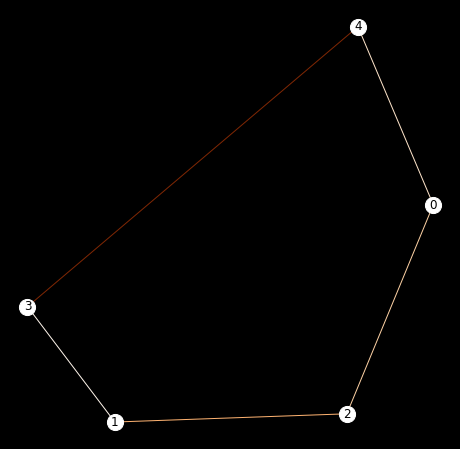

In [31]:
if n <= 100:                                                                                                                            
    fig, ax = plt.subplots()                                                                                                            
    draw(W, pos = gpos,                                                                                                                 
         edge_cmap = plt.get_cmap('Oranges'),                                                                                           
         edge_color = [ edgecosts[(v, w)] for v, w in W.edges() ],                                                                      
         **opt)                                                                                                                         
    ax.set_facecolor('black')                                                                                                           
    fig.set_facecolor('black')                                                                                                          
    ax.axis('off')                                                                                                                      
    plt.show()                                                                                                        
    plt.close()  

The next idea was starting with a minimum spanning tree (MST). We shall recurr to Kruskal's algorithm (a very didactive implementation, no fancy optimizations here).

In [33]:
from collections import defaultdict # easy storage                                                                                                                                                                                                            
import operator # for getting extrema from dictionaries  
start = time()                                                                                                                          
mst = set()                                                                                                                             
components = dict() # connected-component storage                                                                                       
mstcost = 0 # cost accumulator                                                                                                          
neighbors = defaultdict(set)                                                                                                            
candidates = edgecosts.copy()                                                                                                           
while len(candidates) > 0: # Kruskal's algorithm for MST                                                                                
    cheapest = min(candidates.items(), key = operator.itemgetter(1))[0]                                                                 
    (v, w) = cheapest                                                                                                                   
    value = edgecosts[cheapest]                                                                                                         
    del candidates[cheapest] # remove the processed edges                                                                               
    connected = components.get(v, {v})                                                                                                  
    if w not in connected:                                                                                                              
        mst.add(cheapest) # use this edge                                                                                               
        neighbors[v].add(w)                                                                                                             
        neighbors[w].add(v)                                                                                                             
        mstcost += value                                                                                                                
        combination = connected.union(components.get(w, {w}))                                                                           
        if len(combination) == n: # everyone is now connected                                                                           
            break                                                                                                                       
        for u in combination:                                                                                                           
            components[u] = combination                                                                                                 
print(f'The minimum spanning tree costs {mstcost:.2f}')     

The minimum spanning tree costs 1.33


Again, if we make a copy of the graph and strip it down so that only the edges included in the MST remain, we get to visualize the result.

The idea with making an MST is running it back and forth to make a tour that closes but makes too many intermediate visits. We will use depth-first search (DFS) for this purpose.

In [43]:
route = []                                                                                                                              
visited = set()                                                                                                                         
                                                                                                                                        
def dfs(v):                                                                                                                             
    global route, neighbors, visited                                                                                                    
    route.append(v)                                                                                                                     
    visited.add(v)                                                                                                                      
    cand = neighbors[v] - visited # unvisited                                                                                           
    for w in cand:                                                                                                                      
        dfs(w)                                                                                                                          
        route.append(v)                                                                                                                 
start = time()                                                                                                                          
dfs(0)                                                                                                                                  
if n <= 10:                                                                                                                             
    print('Back and forth', route)                                                                                                      
bfcost = cost(G, route)                                                                                                                 
print(f'The back-and-forth MST costs {bfcost:.2f}')                                                                                     
timestamp(start)                

Back and forth [0, 2, 1, 3, 1, 2, 0, 4, 0]
The back-and-forth MST costs 2.66
That took 1.14 ms of runtime


Since this in infeasible as a solution because of the repeated visits, we give kudos to the Euclidean distance that satisfies the triangle inequality and happily skip ahead whenever we face the need to backtrack.

In [46]:
start = time()                                                                                                                          
prev = 0 # start at zero again                                                                                                          
st = [ 0 ]
for cand in route:                                                                                                                                                                                                                           
    if cand not in st: # skip ahead if already visited                                                                             
        st.append(cand)                                                                                                                                                                                                                              
st.append(0) # close the loop                                                                                                     
if n <= 10:                                                                                                                             
    print('Straighted out', st)
for i in range(n):                                                                                                                                                                                                                                            
    assert i in st                                                                                                       
scost = cost(G, st)                                                                                                               
print(f'The straightened-out MST cycle costs {scost:.2f}')                                                                              
timestamp(start)  
memories['MST'] = st 

Straighted out [0, 2, 1, 3, 4, 0]
The straightened-out MST cycle costs 2.07
That took 0.24 ms of runtime


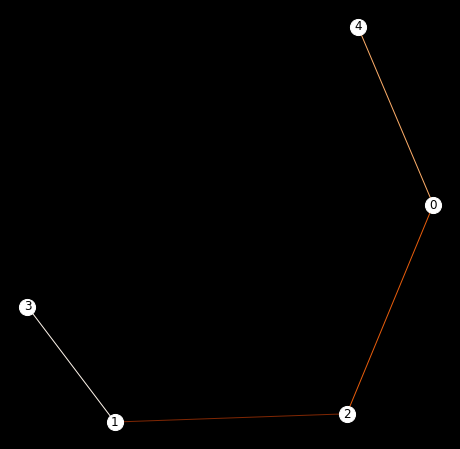

In [47]:
M = G.copy() # make a copy                                                                                                              
removed = G.edges() - mst                                                                                                               
M.remove_edges_from(removed)                                                                                                            
if n <= 150:                                                                                                                            
    fig, ax = plt.subplots()                                                                                                            
    draw(M, pos = gpos,                                                                                                                 
         edge_cmap = plt.get_cmap('Oranges'),                                                                                           
         edge_color = [ edgecosts[(v, w)] for v, w in M.edges() ],                                                                      
         **opt)                                                                                                                         
    ax.set_facecolor('black')                                                                                                           
    fig.set_facecolor('black')                                                                                                          
    ax.axis('off')                                                                                                                      
    plt.show(f'mst{n}.png')                                                                                                          
    plt.close()                       

To see what this looks like, we will strip edges off yet another copy of the original graph.

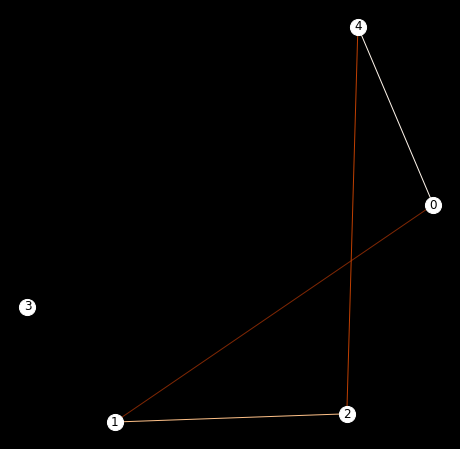

In [48]:
S = G.copy() # make a copy of the graph                                                                                                 
S.remove_edges_from(G.edges() - used(straight))                                                                                         
if n <= 150:                                                                                                                            
    fig, ax = plt.subplots()                                                                                                            
    draw(S, pos = gpos,                                                                                                                 
         edge_cmap = plt.get_cmap('Oranges'),                                                                                           
         edge_color = [ edgecosts[(v, w)] for v, w in S.edges() ],                                                                      
         **opt)                                                                                                                         
    ax.set_facecolor('black')                                                                                                           
    fig.set_facecolor('black')                                                                                                          
    ax.axis('off')                                                                                                                      
    plt.show()                                                                                                       
    plt.close()           

Fancier people have better ideas on how to build an MST-based route that lower that upper bound down to 1.5 times the optimum; you can check out the [Christofides algorithm](https://en.wikipedia.org/wiki/Christofides_algorithm) if you want to see how. 

For the local search, we wanted the 2-opt heuristic that takes two edges *(a, b)* and *(c, d)* along the route and then then switched it around going from *a* to *c*, then backwards the original route from *b* to *c* and then continue from *b* to *d*, after which the rest of the route is as before. The result here is that the edges *(a, b)* and *(c, d)* were removed and in their place we now have the edges *(a, c)* and *(b, d)*, so if the sum of the costs of the former exceed that of the latter, we win a little.

In [49]:
def twoopt(route):                                                                                                                      
    n = len(route)                                                                                                                      
    f = randint(1, n - 2) # first cut                                                                                                   
    s = randint(f + 1, n - 1) # second cut                                                                                              
    start = route[:f]                                                                                                                   
    middle = route[f:s] # to invert                                                                                                     
    finish = route[s:]                                                                                                                  
    assert len(start) > 0 and len(middle) > 0 and len(finish) > 0                                                                       
    return start + middle[::-1] + finish   

Since the way we are thinking this requires the two edges to be in the middle of the route instead of at the end of the beginning, we can also just roll the route around since it is a cycle and it does not *really* matter where we start.

In [50]:
def roll(route):                                                                                                                       
    n = len(route)                                                                                                                     
    assert route[0] == route[-1]                                                                                                       
    route.pop() # remove the last                                                                                                      
    offset = randint(1, n - 2)                                                                                                         
    assert offset < len(route)                                                                                                         
    rolled = route[offset:] + route[:offset]                                                                                           
    return rolled + [ rolled[0] ] # close it back                   

Our final touch to clean it out with 2-opt use *local search* to exchange some of those bad shortcuts for better ones using 2-opt and rolling in between. 

We will use **simulated annealing** that lets us move from the *current* solution to a worse one, so we must keep at all times a copy of the *best* solution we have seen thus far so that we never lose that upper bound of being no more than twice above the cost of the MST. 

You can mess with the initial temperature `T`and the cooling schedule `eps` to alter the probability with which worse solutions are accepted. Changing the `maximum` affects the amount of iterations that the search is allow to "stall" without improvement.

In [54]:
# simulated annealing                                                                                                                                                                                                                                         
def simAnn(G, current, stuck, maximum, quiet = False, T = 1000, cooling = 0.999, eps = 0.01):                                                                                                                                                                                                            
    stalled = 0                                                                                                                                                                                                                                               
    stable = 0                                                                                                                                                                                                                                                
    cheapest = current.copy()                                                                                                                                                                                                                                 
    lcost = ccost = cost(G, current)                                                                                                                                                                                                                          
    i = 0                                                                                                                                                                                                                                                     
    while stalled < maximum and T > eps:                                                                                                                                                                                                                      
        modified = twoopt(current)                                                                                                                                                                                                                            
        assert len(modified) == n + 1                                                                                                                                                                                                                         
        mcost = cost(G, modified)                                                                                                                                                                                                                             
        d = ccost - mcost                                                                                                                                                                                                                                     
        if mcost < lcost: # a new low (a good thing here)                                                                                                                                                                                                     
            if not quiet:                                                                                                                                                                                                                                     
                print(f'New low at {mcost:.2f} on iteration {i} at temp {T:.2f}')                                                                                                                                                                             
            cheapest = modified.copy()                                                                                                                                                                                                                        
            lcost = mcost                                                                                                                                                                                                                                     
            if d > eps:                                                                                                                                                                                                                                       
                stable += 1                                                                                                                                                                                                                                   
                if stable > stuck:                                                                                                                                                                                                                            
                    stalled = maximum                                                                                                                                                                                                                         
                    continue                                                                                                                                                                                                                                  
            else:                                                                                                                                                                                                                                             
                stable = 0 # notable improvement                                                                                                                                                                                                              
        threshold = exp(d / T) # probability                                                                                                                                                                                                                  
        i += 1                                                                                                                                                                                                                                                
        if random() < threshold: # accept                                                                                                                                                                                                                     
            current = roll(modified) # change the start position (for varying 2-opt)c                                                                                                                                                                         
            assert current[0] == current[-1]                                                                                                                                                                                                                  
            ccost = mcost                                                                                                                                                                                                                                     
            if d > 0: # it was better                                                                                                                                                                                                                         
                T *= cooling # get stricter                                                                                                                                                                                                                   
                stalled = 0                                                                                                                                                                                                                                   
                continue                                                                                                                                                                                                                                      
        stalled += 1                                                                                                                                                                                                                                          
    return cheapest                                                                                                                                                                                                                                           
                                                                                                                                                                                                                                                              
start = time()                                                                                                                                                                                                                                                
# start with a copy of the straightened-out route                                                                                                                                                                                                             
cheapest = simAnn(G, st.copy(), magn, 200 * magn)                                                                                                                                                                                                             
memories['SA'] = cheapest                                                                                                                                                                                                                                     
timestamp(start)                                                   

That took 239.20 ms of runtime


Finally, we can look at the fruit of our labor.

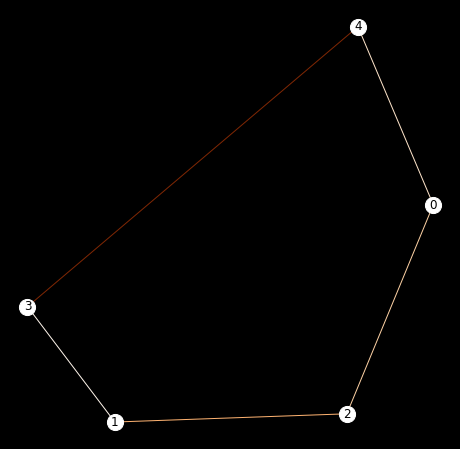

In [55]:
if n <= 150:                                                                                                                           
    F = G.copy() # make a copy of the graph                                                                                            
    F.remove_edges_from(G.edges() - used(cheapest))                                                                                    
    fig, ax = plt.subplots()                                                                                                           
    draw(F, pos = gpos,                                                                                                                
         edge_cmap = plt.get_cmap('Oranges'),                                                                                          
         edge_color = [ edgecosts[(v, w)] for v, w in F.edges()  ],                                                                    
         **opt)                                                                                                                        
    ax.set_facecolor('black')                                                                                                          
    fig.set_facecolor('black')                                                                                                         
    ax.axis('off')                                                                                                                     
    plt.show()                                                                                                       
    plt.close()    

What if we used deep learning instead since it is so popular now?
Beware: calculations will start taking time again. We start by creating a *training set* that contains "good" (should be affordable) and "bad" (probably expensive) routes. The more we make, the better our machine-learning model will be, but for a quick learning experience, it is best not to exaggerate.

In [61]:
k = 250
routes = []
for r in range(k // 2): # make half "good ones", half "bad ones"                                                                                                                                                                                              
    good = simAnn(G, st.copy(), magn, 50 * magn, quiet = True)                                                                                                                                                                                                
    routes.append(good)                                                                                                                                                                                                                                       
    bad = good.copy()[:-1] # unclosed                                                                                                                                                                                                                         
    shuffle(bad) # random walk                                                                                                                                                                                                                                
    bad.append(bad[0]) # closed                                                                                                                                                                                                                               
    routes.append(bad)                                                                                                                                                                                                                                        
    if r % 25 == 0:                                                                                                                                                                                                                                           
        print('.') # progress indicator                                                                                                                                                                                                                       
print('Training data ready')                                                                                                                                                                                                                                  
timestamp(start)
shuffle(routes) # put them in random order
import numpy as np # we need a matrix                                                                                                                                                                                                                         
X = np.array(routes)  

.
.
.
.
.
Training data ready
That took 415498.34 ms of runtime


We have a bunch of routes. We need *labels* for them to tell the good and the bad ones apart. We can use a threshold based on upper bounds known for the approximate solutions: the 3/2 one is the bound for another approximation algorithm we have not discussed today (called the *Christophides bound*) and that twice-the-MST is what we spoke of. You can read [a cool story](https://www.wired.com/story/computer-scientists-break-the-traveling-salesperson-record/) later :)

We will label those that are cheaper than 3/2 * MST as "okay" (True = 1), and those that are more expensive as "not okay" (False = 0).

In [59]:
demanding = (3 / 2) * mstcost # the Christophides upper bound                                                                                                                                                                                                 
relaxed = 2 * mstcost # the upper bound we discussed                                                                                                                                                                                                          
threshold = (demanding + relaxed) / 2 # compromise at the average      

In [62]:
# these are the intended labels as a column vector                                                                                                                                                                                                            
y = np.array([ cost(G, r) < threshold for r in routes ]).T # transpose                                                                                                                                                                                        
labels, counts = np.unique(y, return_counts = True)                                                                                                                                                                                                           
assert len(counts) == 2 # we _need_ both kinds                                                                                                                                                                                                                
for (l, c) in zip(labels, counts):                                                                                                                                                                                                                            
    print(f'Training with {c} routes with label {l}')  

Training with 87 routes with label False
Training with 163 routes with label True


Now we will build a deep learning model by creating and connecting *layers*.
If you do this on your computer, also install TensorFlow although we do not explicitly import it as `keras` needs a backend.                                                                                                                                                   
- the route is the input                                                                     
- we use a *rectified linear unit activation function*                                       
- you can play with the number and kind of the hidden layers to see what happens 
- we use a single value as an output and will use a sigmoidal activation function

The model will have five layers: an input, THREE hidden ones, and an output layer.

In [65]:
from keras.models import Sequential # increment the layers one at a time                                                                                                                                                                                      
from keras.layers import Dense # everything is connected to everything                                                                                                                                                                                                                                                                                                                                                                                          
m = Sequential()                                                                                                                                                                                                                                              
m.add(Dense(16, input_dim = n + 1, activation = 'relu'))                                                                                                                                                                           
m.add(Dense(8, activation = 'relu')) #                                                                                                                                                                             
m.add(Dense(4, activation = 'relu')) # picking which ones and how many is an artform                                                                                                                                                                          
m.add(Dense(1, activation = 'sigmoid')) # this will output the 0/1                    

We are training a binary model since we have two classes. Our optimizer will be a probabilistic gradient descent, and we are interested in the *accuracy* of the resulting model (how well the labels we create with ML match the ones we expect based on the route cost and the threshold we set for it).

The number of rounds to make (called *epochs*) and after how many samples to update the weights in the optimizer are our parameters. We will do just a handful of epocs since we are learning and want to run it many times to play with it. For real-world problems, the we might need more and each one may take a day or more to complete.

In [66]:
start = time()                                                                                                                                                                                                                                                
m.compile(loss = 'binary_crossentropy', # two classes                                                                                                                                                                                                 
              optimizer = 'adam',                                                                                                                                                                                               
              metrics = [ 'accuracy' ]) # performance measure                                                                                                                                                                                                 
m.fit(X, y, epochs = 50, batch_size = 10, verbose = 0)                                                                                                                                                                                                                                                                                                                                                                                    
timestamp(start)  

That took 1060.70 ms of runtime


Now, we need to see how well that works. Let's make a totally independent set of routes for testing. It is important to test with data that the model has never seen so that we do not introduce a bias. We can test with much less data than we used for training.

In [68]:
k = 60 # this can be smaller                                                                                                                                                                                                                                  
testroutes = []                                                                                                                                                                                                                                               
for r in range(k // 2): # half good, half bad                                                                                                                                                                                                                 
    good = simAnn(G, st.copy(), magn, 50 * magn, quiet = True)                                                                                                                                                                                                
    testroutes.append(good)                                                                                                                                                                                                                                   
    bad = good.copy()[:-1]                                                                                                                                                                                                                                    
    shuffle(bad)                                                                                                                                                                                                                                              
    bad.append(bad[0])                                                                                                                                                                                                                                        
    testroutes.append(bad)                                                                                                                                                                                                                                    
print('Test data ready')   

testX = np.array(testroutes)                                                                                                                                                                                                                                  
testy = np.array([ cost(G, r) < threshold for r in testroutes ]).T                                                                                                                                                                                            
labels, counts = np.unique(testy, return_counts = True)                                                                                                                                                                                                       
assert len(counts) == 2 # we again _need_ both kinds                                                                                                                                                                                                          
for (l, c) in zip(labels, counts):                                                                                                                                                                                                                            
    print(f'Testing with {c} routes with label {l}')  

Test data ready
Testing with 19 routes with label False
Testing with 41 routes with label True


So, now we *evaluate* the model using this test data. In the big leagues, we would do cross-validation, but we can talk about that later. Now we just make the model add labels to the test data without peeking at the ones we want, then compare the obtained labels to the expected ones and count how much it screwed up.

In [69]:
for (metric, value) in zip(m.metrics_names, m.evaluate(testX, testy)):                                                                                                                                                                                        
    print(f'Performance metric {metric} was {value:.3f} in the test')     

2/2 [==============================] - 0s 2ms/step - loss: 0.3319 - accuracy: 0.9667
Performance metric loss was 0.332 in the test
Performance metric accuracy was 0.967 in the test


Remember that we never told the model we were solving the TSP so it has no knowledge of what the numbers in the inputs or the outputs *mean*.                                                                                                                                        Using the routes we memorized before, we can see for ourselves how well this works. We can make the model *predict* their label and we can then compare it with whether the cost of the route is or is not below that threshold we set.

In [71]:
order = [ key for key in memories.keys() ]                                                                                                                                                                                                                    
X = np.array([ memories[r] for r in order ])                                                                                                                                                                                                                  
output = m.predict(X)    

# remember: this will look different every time you run it                                                                                                                                                                                                    
happy, sad = 0, 0                                                                                                                                                                                                                                             
for (result, key) in zip(output, order):                                                                                                                                                                                                                      
    route = memories[key]                                                                                                                                                                                                                                     
    expected = cost(G, route) < threshold                                                                                                                                                                                                                     
    observed = result[0] > 0.5 # sigmoidal threshold                                                                                                                                                                                                          
    match = observed == expected                                                                                                                                                                                                                              
    outcome = ':)' if match else ':('                                                                                                                                                                                                                         
    happy += match                                                                                                                                                                                                                                            
    sad += not match                                                                                                                                                                                                                                          
    print(f'{outcome} for {key}\twanted {expected}\t got {observed}\t(raw: {result})')                                                                                                                                                                        
hp = 'es' if happy > 1 else ''                                                                                                                                                                                                                                
sp = 'es' if sad > 1 else ''                                                                                                                                                                                                                                  
print(f'That is {happy} match{hp} and {sad} mismatch{sp}.')  

:) for BRW	wanted True	 got True	(raw: [0.6665115])
:) for RW0	wanted True	 got True	(raw: [0.60049105])
:) for RW1	wanted False	 got False	(raw: [0.254674])
:) for RW2	wanted False	 got False	(raw: [0.15171027])
:) for RW3	wanted True	 got True	(raw: [0.60047954])
:) for RW4	wanted False	 got False	(raw: [0.03661643])
:) for MST	wanted True	 got True	(raw: [0.72159135])
:) for SA	wanted True	 got True	(raw: [0.72159135])
That is 8 matches and 0 mismatch.
